# Base line substraction


This code allows to : 
- substract a base line to UV spectrum
- deconvuluate spectrum in 3 peaks



[ 8.15090980e+01 -1.04483927e-02  9.84456378e-02]


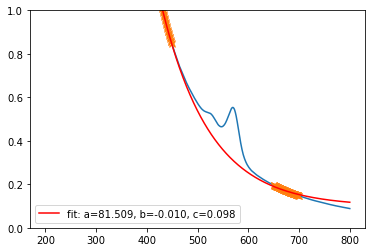

570.5


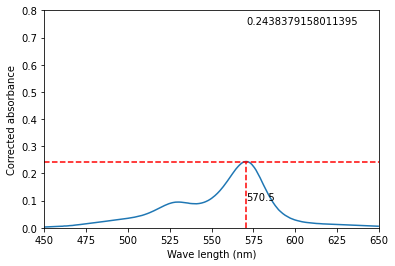

Concentration 2.261947270882556e-06 mol/L


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

file_coord='20240516_AXD045_300s.txt'

#Download the data from the txt file
xdata = []
ydata = []
f=open(file_coord,'r')
lignes =f.readlines()
f.close()
nbrec = len(lignes)
for rec in range(2,nbrec):
    laligne = lignes[rec].split(',')
    xdata.append(float(laligne[0]))
    ydata.append(float(laligne[1]))
    
plt.plot(xdata, ydata)
xdata=np.array(xdata)

#range of values to fit the base line
bs=np.array([400,450,650,700])

#extract data from the range
pos=2*(bs-200)
xdatar1=xdata[pos[0]: pos[1]]
xdatar2=xdata[pos[2]: pos[3]]
ydatar1=ydata[pos[0]: pos[1]]
ydatar2=ydata[pos[2]: pos[3]]
xdatar=np.append(xdatar1, xdatar2)
ydatar=np.append(ydatar1, ydatar2)
plt.plot(xdatar, ydatar, 'x')

#function to fit the baseline
def fit(x,a,b,c):
    return a*np.exp(b*x)+c

#initialisation
p0=np.array([10,-0.01,0.1])
#plt.plot(xdata, fit(xdata, *p0), 'g-')

#fit
popt, pcov = curve_fit(fit, xdatar, ydatar,p0)
plt.plot(xdata, fit(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
print(popt)
plt.ylim(0,1)
plt.show()

#base line substraction
spectre=ydata-fit(xdata, *popt)
spectre=spectre[pos[1]:pos[2]]
wl=xdata[pos[1]:pos[2]]
maxi=np.max(spectre)
index = np.argmax(spectre)
print (wl[index])

wl1=wl
spectre1=spectre
plt.plot(wl1, spectre1)
plt.plot([450,650], [maxi,maxi], 'r--')
plt.plot([wl1[index],wl1[index]], [0,maxi], 'r--')
plt.text(wl1[index],0.75,maxi)
plt.text(wl1[index],0.1,wl1[index])
plt.xlim(450,650)
plt.ylim(0,0.8)
plt.xlabel('Wave length (nm)')
plt.ylabel('Corrected absorbance')
plt.show()

epsilon=107800
c=maxi/epsilon
print('Concentration', c, 'mol/L')

file =file_coord+'_cor.csv'
with open(file, mode='w', newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(['Wavelength','Abs','Abs corrected'])
    for i in range(len(xdata)):
        ligne=[xdata[i],ydata[i],ydata[i]-fit(xdata, *popt)[i]]
        writer.writerow(ligne)   


# Peak deconvolution

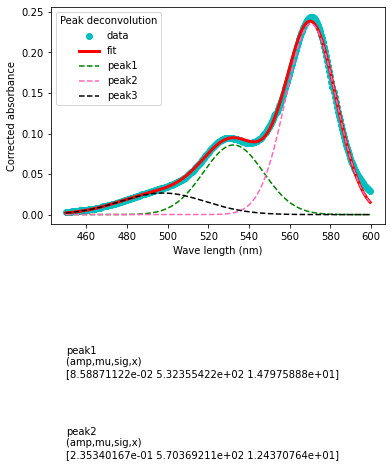

rapport d agregation 2.740110372083402


In [45]:
wl=wl[:-100]
spectre=spectre[:-100]
def gaussian(x,amp,mu,sig):
    gauss=amp*np.exp(-(x-mu)**2/(2*sig**2))
    return gauss

def t_gaussian(x,amp1,mu1,sig1,amp2,mu2,sig2,amp3,mu3,sig3):
    gauss1= amp1*np.exp(-(x-mu1)**2/(2*sig1**2))
    gauss2= amp2*np.exp(-(x-mu2)**2/(2*sig2**2))
    gauss3= amp3*np.exp(-(x-mu3)**2/(2*sig3**2))
    return gauss1+gauss2+gauss3

#initialization (heigh, position, thickness)
init=[0.2,525,30,1,575,20,0.1,490,20]
#limit= lower , upper
limit=((0.05,500,10,0.1,550,10,0.01,470,10),(1,550,50,2,600,50,0.2,500,50))
popt,pcov=curve_fit(t_gaussian, wl,spectre, p0=init,bounds=limit)
yfit=t_gaussian(wl,*popt)

yfit1=gaussian(wl,*popt[0:3])
yfit2=gaussian(wl,*popt[3:6])
yfit3=gaussian(wl,*popt[6:9])

plt.plot(wl, spectre,'co',label='data')
plt.plot(wl, yfit,'r',linewidth=3,label='fit')
plt.plot(wl, yfit1,'g--',label='peak1')
plt.plot(wl, yfit2,color='hotpink',linestyle='dashed',label='peak2')
plt.plot(wl, yfit3,'k--',label='peak3')
plt.xlabel('Wave length (nm)')
plt.ylabel('Corrected absorbance')
plt.legend(title='Peak deconvolution')

plt.text(450,-0.2,r'peak1'+'\n(amp,mu,sig,x) \n'+str(popt[0:3]))
plt.text(450,-0.3,r'peak2'+'\n(amp,mu,sig,x) \n'+str(popt[3:6]))
plt.show()


print ('rapport d agregation',popt[3]/popt[0]  )


file =file_coord+'_deconv.csv'
with open(file, mode='w', newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(['Wavelength','Abs','Abs model','Abs peak1','Abs peak2','Abs peak3'])
    writer.writerow([' ',' ','Abs max',popt[0],popt[3],popt[6]])
    writer.writerow([' ',' ','wl peak',popt[1],popt[4],popt[7]])
    writer.writerow([' ',' ','sigma',popt[2],popt[5],popt[8]])
    writer.writerow([' ',' ','surf',popt[2]*np.sqrt(2*np.pi)*popt[0],popt[5]*np.sqrt(2*np.pi)*popt[3],popt[8]*np.sqrt(2*np.pi)*popt[6]])
    for i in range(len(wl)):
        ligne=[wl[i],spectre[i],yfit[i],yfit1[i],yfit2[i],yfit3[i]]
        writer.writerow(ligne)   